In [421]:
import matplotlib.pylab as plt
import sys
import numpy as np
import pandas as pd

import itertools as it

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [422]:
data_bkg = np.load('shield_cands_muons.npz')
print(data_bkg.files)

['W', 'Pdg', 'X', 'Y', 'Z', 'Px', 'Py', 'Pz']


In [423]:
w_bkg = data_bkg['W']
X_bkg = pd.DataFrame({'X': data_bkg['X'], 'Y': data_bkg['Y'],
                      'Px': data_bkg['Px'], 'Py': data_bkg['Py'], 'Pz': data_bkg['Pz']})

In [424]:
data_sig = np.load('HNL_100k_ecn3_geom_1_4_ch_muons.npz')
print(data_sig.files)

['W', 'Vx', 'Vy', 'Vz', 'Pdg', 'X', 'Y', 'Z', 'Px', 'Py', 'Pz']


In [425]:
w_sig = data_sig['W']
X_sig = pd.DataFrame({'X': data_sig['X'], 'Y': data_sig['Y'],
                      'Px': data_sig['Px'], 'Py': data_sig['Py'], 'Pz': data_sig['Pz']})


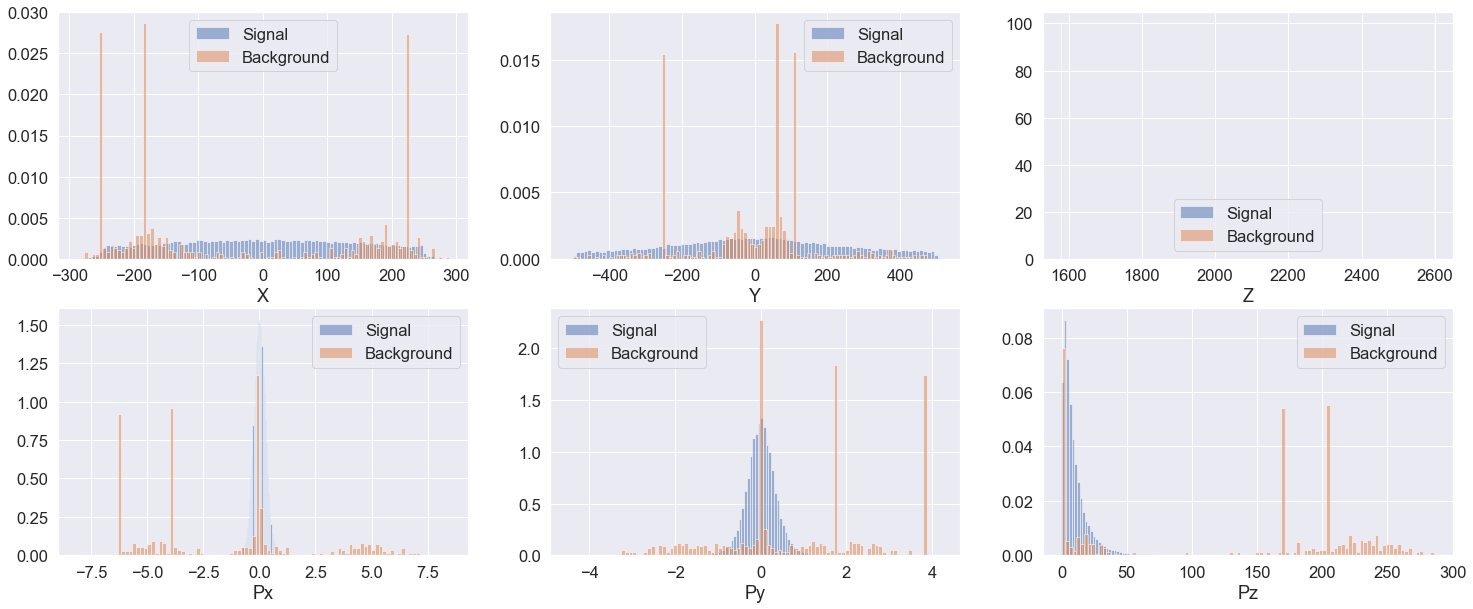

In [426]:
plt.figure(figsize=(25, 10))

for num, val in enumerate(['X', 'Y', 'Z', 'Px', 'Py', 'Pz']):

    plt.subplot(2, 3, num + 1)

    plt.hist(data_sig[val], weights=w_sig, label='Signal', density=True, bins=100, alpha=0.5)
    plt.hist(data_bkg[val], weights=w_bkg, label='Background', density=True, bins=100, alpha=0.5)
    
    plt.xlabel(val)
    plt.legend()
    
plt.show()

In [427]:
data = X_bkg.append(X_sig)
data['type'] = np.hstack((np.ones_like(w_bkg), np.zeros_like(w_sig)))

In [428]:
X = data.drop(['type'], axis=1)
y = data['type']

In [429]:
from sklearn.model_selection import train_test_split

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

>## BaseLine

In [431]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score

In [808]:
def get_metrics(X, y, states=[0, 6, 7, 13, 42, 911], size=0.3):

    log_reg_rec = []
    knn_rec = []
    rand_frst_rec = []

    log_reg_prs = []
    knn_prs = []
    rand_frst_prs = []

    for state in states:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=size)
        
        log_reg = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000).fit(X_train, y_train).predict(X_test)
        knn = KNeighborsClassifier(n_jobs=-1).fit(X_train, y_train).predict(X_test)
        rand_frst = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train).predict(X_test)

        log_reg_rec.append(recall_score(y_test, log_reg))
        knn_rec.append(recall_score(y_test, knn))
        rand_frst_rec.append(recall_score(y_test, rand_frst))

        log_reg_prs.append(precision_score(y_test, log_reg))
        knn_prs.append(precision_score(y_test, knn))
        rand_frst_prs.append(precision_score(y_test, rand_frst))

    return pd.DataFrame({'method': ['log_reg', 'knn', 'rand_frst'], 
              'recall': [np.mean(log_reg_rec), np.mean(knn_rec), np.mean(rand_frst_rec)],
              'precision': [np.mean(log_reg_prs), np.mean(knn_prs), np.mean(rand_frst_prs)]})

In [433]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.587687   0.968921
1        knn  0.627948   1.000000
2  rand_frst  0.644075   0.974182

>## Feature-инжиниринг

In [434]:
X['T'] = X['Px'] ** 2 + X['Py'] ** 2 + X['Pz'] ** 2

In [435]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.596730   0.946925
1        knn  0.595353   0.946645
2  rand_frst  0.647195   0.965279

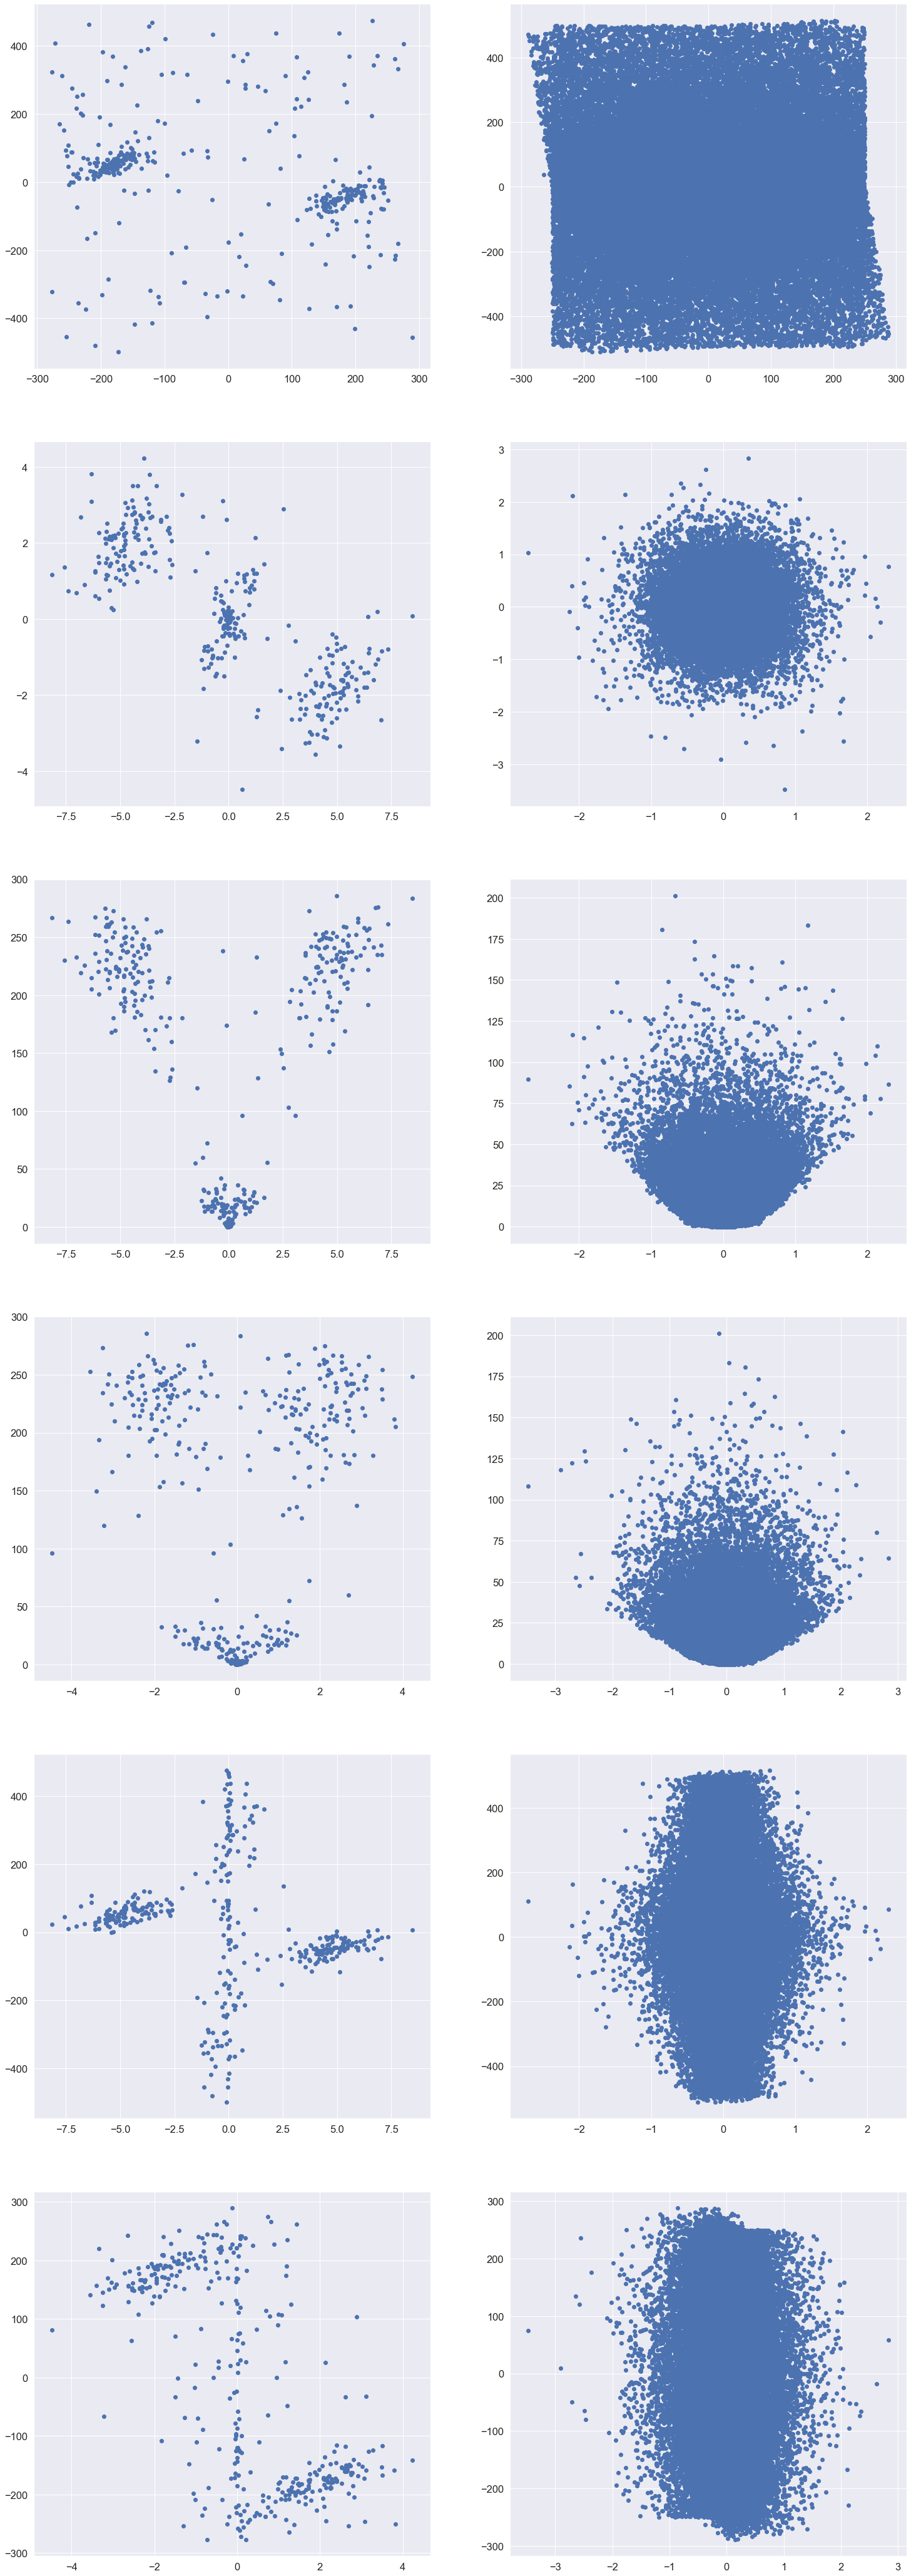

In [436]:
plt.figure(figsize=(25, 75))

plt.subplot(6, 2, 1)
plt.scatter(data_bkg['X'], data_bkg['Y'])

plt.subplot(6, 2, 2)
plt.scatter(data_sig['X'], data_sig['Y'])

plt.subplot(6, 2, 3)
plt.scatter(data_bkg['Px'], data_bkg['Py'])

plt.subplot(6, 2, 4)
plt.scatter(data_sig['Px'], data_sig['Py'])

plt.subplot(6, 2, 5)
plt.scatter(data_bkg['Px'], data_bkg['Pz'])

plt.subplot(6, 2, 6)
plt.scatter(data_sig['Px'], data_sig['Pz'])

plt.subplot(6, 2, 7)
plt.scatter(data_bkg['Py'], data_bkg['Pz'])

plt.subplot(6, 2, 8)
plt.scatter(data_sig['Py'], data_sig['Pz'])

plt.subplot(6, 2, 9)
plt.scatter(data_bkg['Px'], data_bkg['Y'])

plt.subplot(6, 2, 10)
plt.scatter(data_sig['Px'], data_sig['Y'])

plt.subplot(6, 2, 11)
plt.scatter(data_bkg['Py'], data_bkg['X'])

plt.subplot(6, 2, 12)
plt.scatter(data_sig['Py'], data_sig['X'])

plt.show()

In [437]:
def transform(x, y, bx=None, by=None):
    
    if not bx:
        bx = (x.max(), x.min())
    if not by:
        by = (y.max(), y.min())
    
    e = 2 * (x - (bx[0] + bx[1]) / 2) / (bx[0] - bx[1])
    n = 2 * (y - (by[0] + by[1]) / 2) / (by[0] - by[1])

    e1 = e * np.exp(1 / (np.abs(e) ** 2 + 0.3)) * (n + 1.01)
    n1 = n * np.exp(1 / (np.abs(n) ** 2 + 0.3))

    return e1, n1

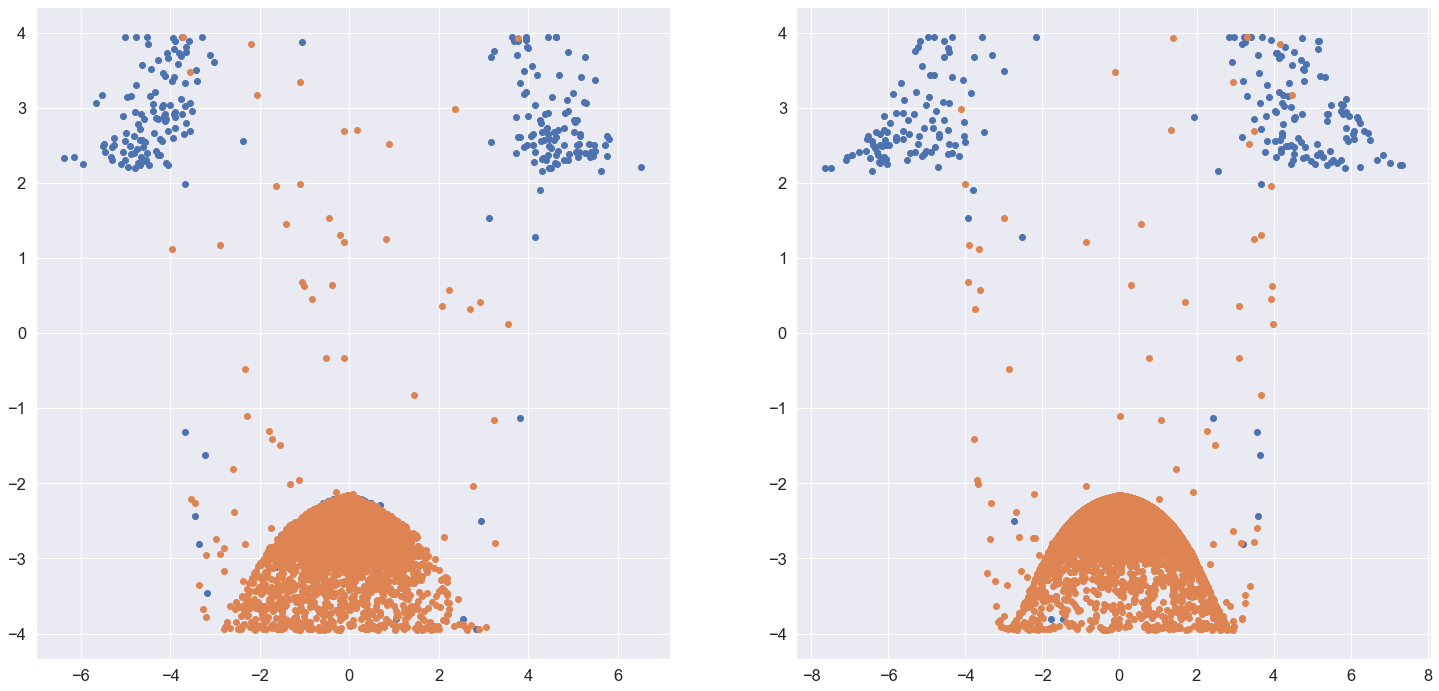

In [438]:
plt.figure(figsize=(25, 12))

plt.subplot(1, 2, 1)
bx = (X_bkg['Px'].max(), X_bkg['Px'].min())
by = (X_bkg['Pz'].max(), X_bkg['Pz'].min())
X_bkg['Px_tr'], X_bkg['Pz_tr'] = transform(X_bkg['Px'], X_bkg['Pz'], bx, by)
plt.scatter(X_bkg['Px_tr'], X_bkg['Pz_tr'])
plt.scatter(transform(X_sig['Px'], X_sig['Pz'], bx, by)[0], transform(X_sig['Px'], X_sig['Pz'], bx, by)[1])

plt.subplot(1, 2, 2)
bx = (X_bkg['Py'].max(), X_bkg['Py'].min())
by = (X_bkg['Pz'].max(), X_bkg['Pz'].min())
X_bkg['Py_tr'], X_bkg['Pz_tr'] = transform(X_bkg['Py'], X_bkg['Pz'], bx, by)
plt.scatter(X_bkg['Py_tr'], X_bkg['Pz_tr'])
plt.scatter(transform(X_sig['Py'], X_sig['Pz'], bx, by)[0], transform(X_sig['Py'], X_sig['Pz'], bx, by)[1])

plt.show()

In [439]:
X['Py_tr'], X['Pz_tr'] = transform(X['Py'], X['Pz'], (X['Py'].max(), X['Py'].min()), (X['Pz'].max(), X['Pz'].min()))
X['Px_tr'], X['Pz_tr1'] = transform(X['Px'], X['Pz'], (X['Px'].max(), X['Px'].min()), (X['Pz'].max(), X['Pz'].min()))

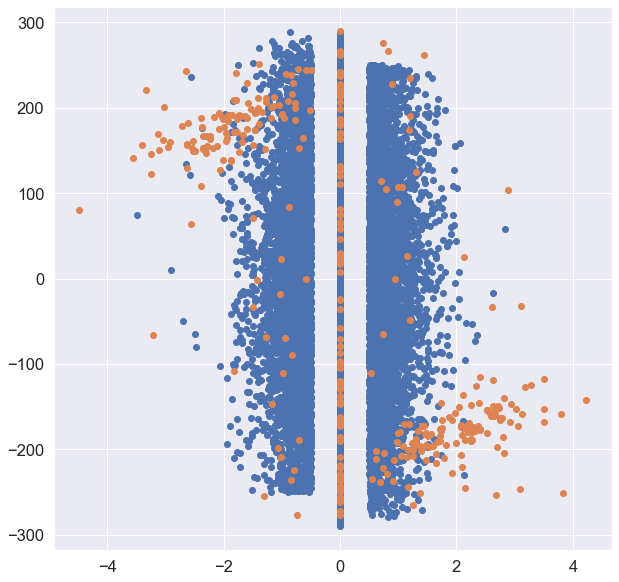

In [440]:
plt.figure(figsize=(10, 10))

plt.scatter(np.where(np.abs(X_sig['Py']) < 0.5, 0, X_sig['Py']), X_sig['X'])
plt.scatter(np.where(np.abs(X_bkg['Py']) < 0.5, 0, X_bkg['Py']), X_bkg['X'])

plt.show()

In [441]:
X['Px_tr1'] = np.where(np.abs(X['Px']) < 0.5, 0, X['Px'])
X['Py_tr1'] = np.where(np.abs(X['Py']) < 0.5, 0, X['Py'])

In [442]:
def best_params(X, y, N, r=7):

    result = np.empty((N, 2), dtype=object)

    num = 0

    for i in range(r, X.columns.size + 1):

        for cols in it.combinations(X.columns, i):

            result[num, 0] = get_metrics(X[list(cols)], y)['recall'].mean()
            result[num, 1] = cols
            num += 1
            if (num == N): break

        if (num == N): break

    return list(result[result[:, 0].argmax()][1])

In [444]:
best = best_params(X, y, 10, 5)

KeyboardInterrupt: 

In [445]:
get_metrics(X[best], y)

method    recall  precision
0    log_reg  0.621320   0.915142
1        knn  0.627948   1.000000
2  rand_frst  0.612256   0.946481

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [471]:
from sklearn.cluster import KMeans 

cluster = KMeans(n_clusters=3, algorithm='lloyd', max_iter=10000).fit(X_train[y_train == 1].drop(['T', 'Px', 'Py', 'Pz', 'X', 'Y'], axis=1))

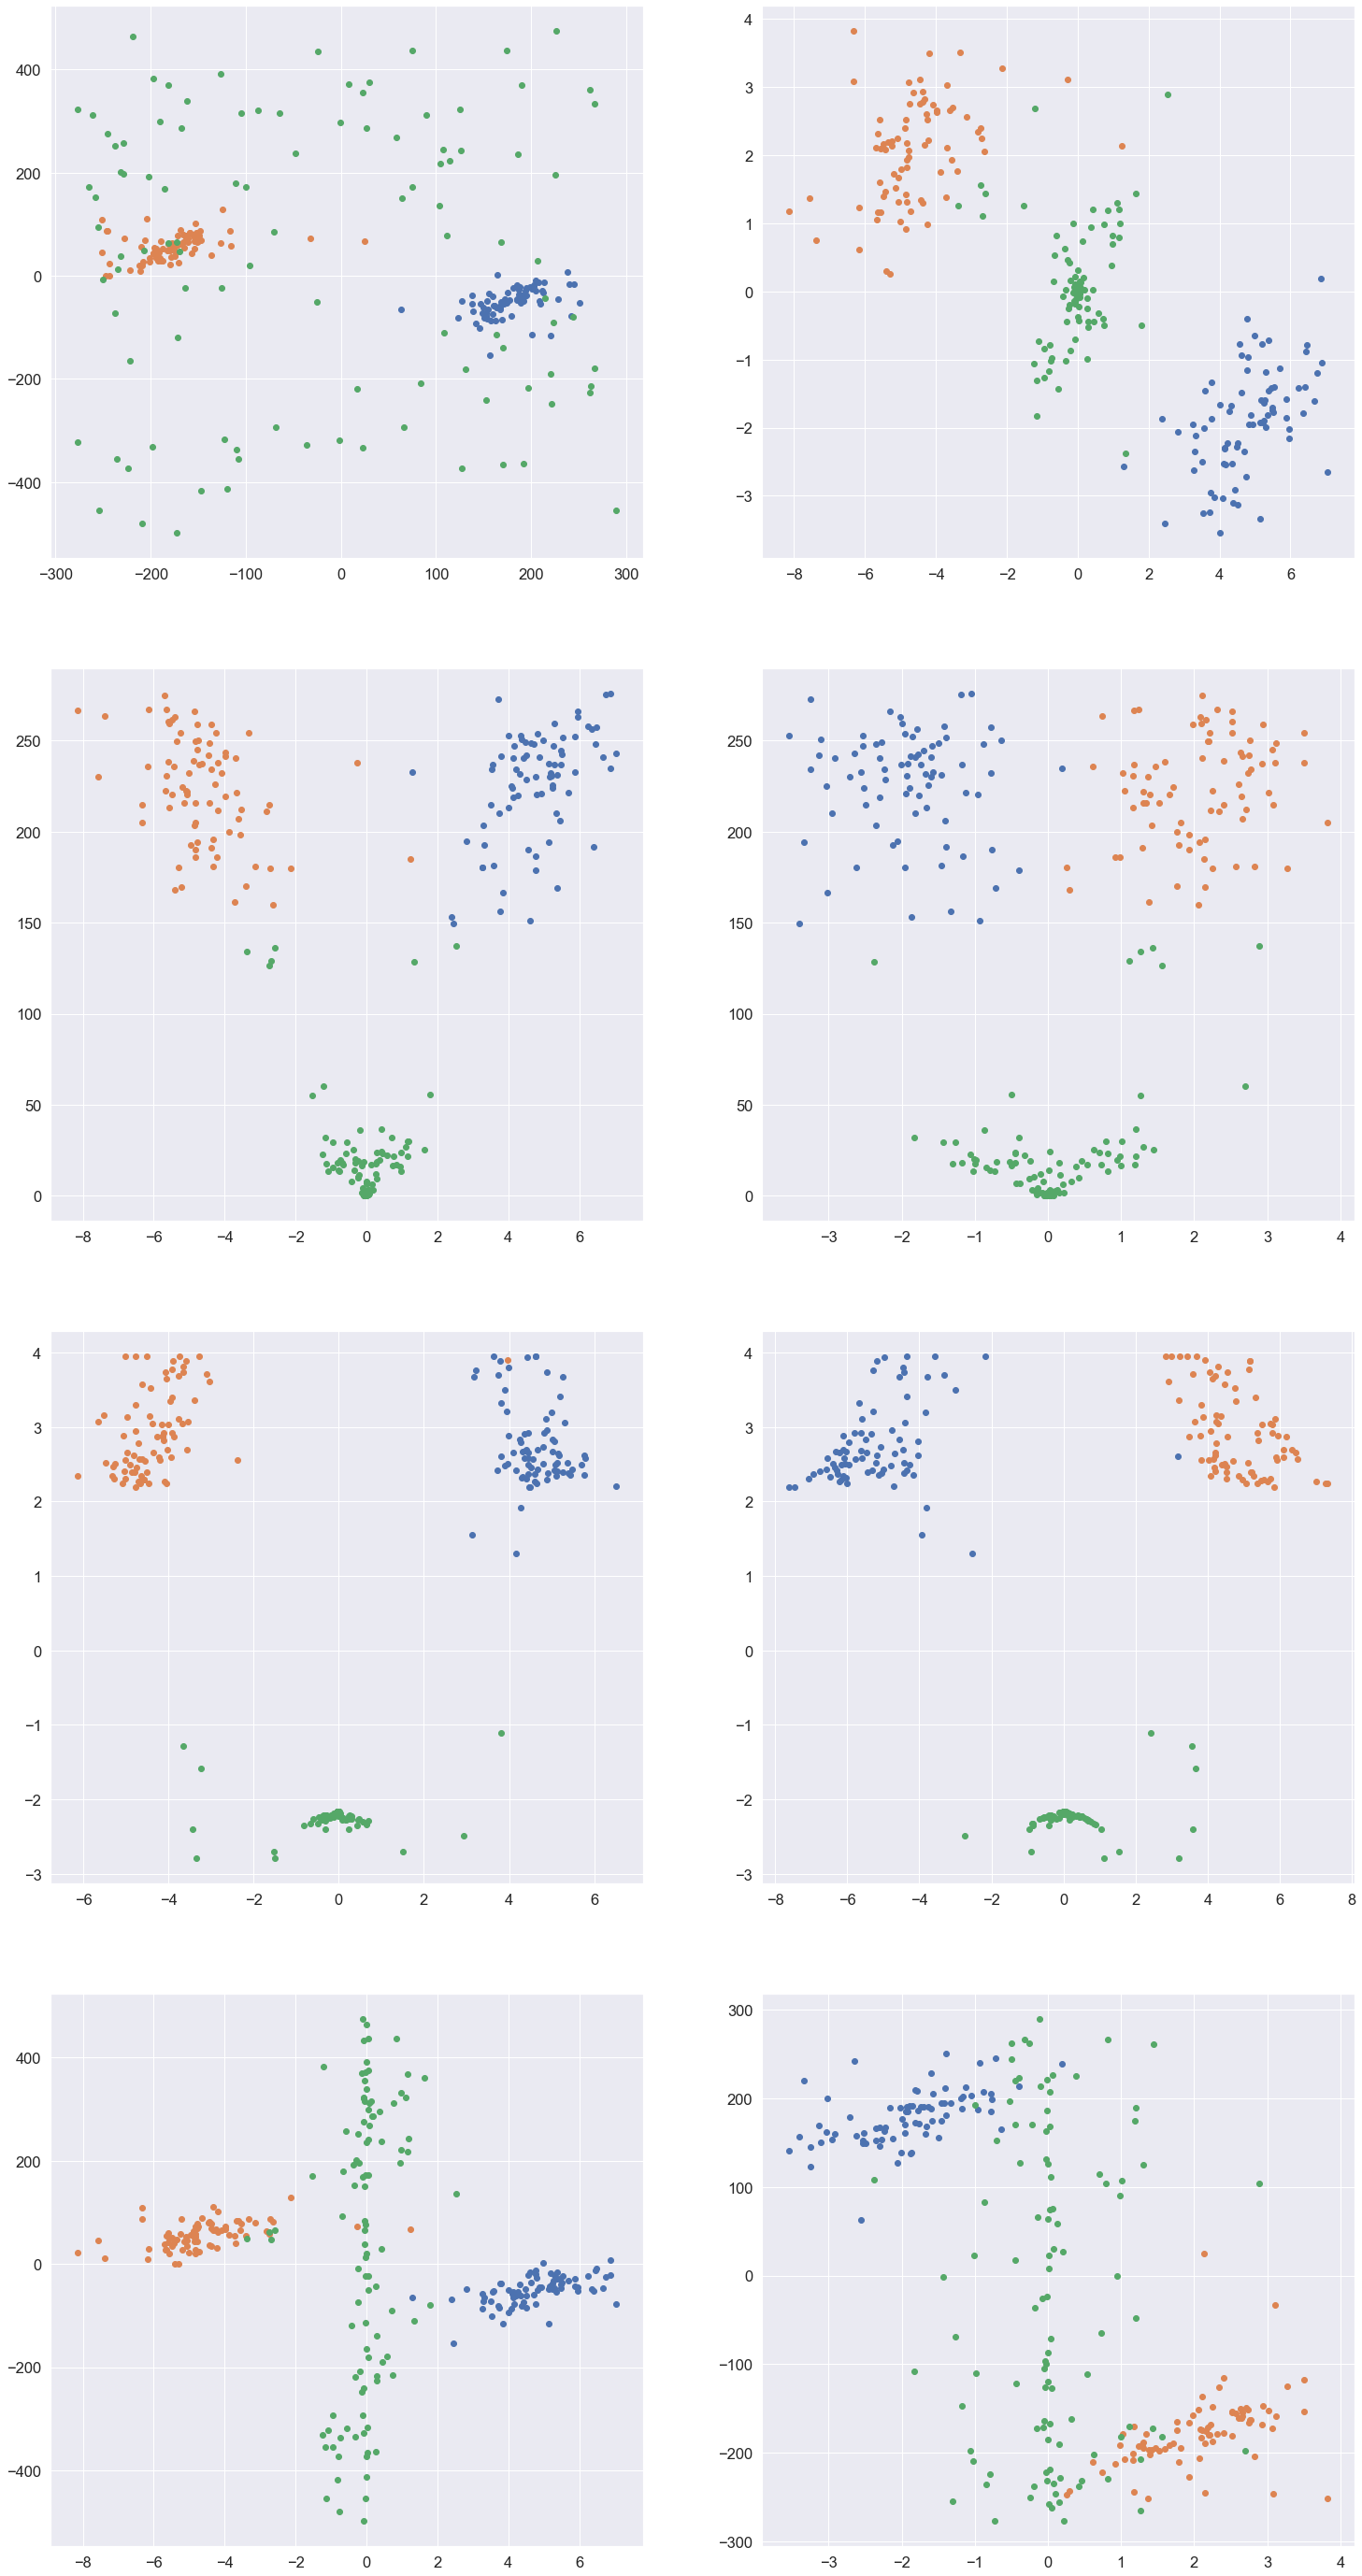

In [472]:
plt.figure(figsize=(25, 50))

plt.subplot(4, 2, 1)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['X'][cluster.labels_ == i], X_train[y_train == 1]['Y'][cluster.labels_ == i])

plt.subplot(4, 2, 2)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px'][cluster.labels_ == i], X_train[y_train == 1]['Py'][cluster.labels_ == i])

plt.subplot(4, 2, 3)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px'][cluster.labels_ == i], X_train[y_train == 1]['Pz'][cluster.labels_ == i])

plt.subplot(4, 2, 4)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Py'][cluster.labels_ == i], X_train[y_train == 1]['Pz'][cluster.labels_ == i])

plt.subplot(4, 2, 5)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px_tr'][cluster.labels_ == i], X_train[y_train == 1]['Pz_tr'][cluster.labels_ == i])

plt.subplot(4, 2, 6)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Py_tr'][cluster.labels_ == i], X_train[y_train == 1]['Pz_tr'][cluster.labels_ == i])

plt.subplot(4, 2, 7)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Px'][cluster.labels_ == i], X_train[y_train == 1]['Y'][cluster.labels_ == i])

plt.subplot(4, 2, 8)
for i in list(set(cluster.labels_)):
    plt.scatter(X_train[y_train == 1]['Py'][cluster.labels_ == i], X_train[y_train == 1]['X'][cluster.labels_ == i])

plt.show()

In [473]:
X1_train = X_train[y_train == 0].append(X_train[y_train == 1][cluster.labels_ == 0])
y1_train = y_train[y_train == 0].append(y_train[y_train == 1][cluster.labels_ == 0])

X2_train = X_train[y_train == 0].append(X_train[y_train == 1][cluster.labels_ == 1])
y2_train = y_train[y_train == 0].append(y_train[y_train == 1][cluster.labels_ == 1])

X3_train = X_train[y_train == 0].append(X_train[y_train == 1][cluster.labels_ == 2])
y3_train = y_train[y_train == 0].append(y_train[y_train == 1][cluster.labels_ == 2])

In [474]:
clust_pred = cluster.predict(X_test.drop(['T', 'Px', 'Py', 'Pz', 'X', 'Y'], axis=1))

X1_test = X_test[clust_pred == 0]
y1_test = y_test[clust_pred == 0]
X1 = X1_train.append(X1_test)
y1 = y1_train.append(y1_test)

X2_test = X_test[clust_pred == 1]
y2_test = y_test[clust_pred == 1]
X2 = X2_train.append(X2_test)
y2 = y2_train.append(y2_test)

X3_test = X_test[clust_pred == 2]
y3_test = y_test[clust_pred == 2]
X3 = X3_train.append(X3_test)
y3 = y3_train.append(y3_test)

In [475]:
get_metrics(X1, y1)

method    recall  precision
0    log_reg  0.989583   0.983744
1        knn  0.944081   0.973810
2  rand_frst  0.983717   1.000000

In [ ]:
best1 = best_params(X1, y1, 100, 5)

In [476]:
get_metrics(X1[best1], y1)

method    recall  precision
0    log_reg  1.000000   0.959413
1        knn  0.944081   0.973810
2  rand_frst  0.983173   0.989286

In [477]:
get_metrics(X2, y2)

method    recall  precision
0    log_reg  0.963758   0.990406
1        knn  0.971676   0.980218
2  rand_frst  0.971449   1.000000

In [ ]:
best2 = best_params(X2, y2, 100, 5)

In [ ]:
get_metrics(X2[best2], y2)

method    recall  precision
0  log_reg  1.000000   0.994048
1      knn  0.994792   1.000000

In [478]:
get_metrics(X3, y3)

method    recall  precision
0    log_reg  0.000000   0.000000
1        knn  0.000000   0.000000
2  rand_frst  0.067874   0.813889

In [479]:
def cluster_metrics(X, y, states=[0, 6, 7, 13, 42, 911], size=0.3):

    log_reg_rec = []
    knn_rec = []
    rand_frst_rec = []

    log_reg_prs = []
    knn_prs = []
    rand_frst_prs = []

    for state in states:

        TP_log_reg = np.empty(len(X))
        FP_log_reg = np.empty(len(X))
        TN_log_reg = np.empty(len(X))
        FN_log_reg = np.empty(len(X))

        TP_knn = np.empty(len(X))
        FP_knn = np.empty(len(X))
        TN_knn = np.empty(len(X))
        FN_knn = np.empty(len(X))

        TP_rand_frst = np.empty(len(X))
        FP_rand_frst = np.empty(len(X))
        TN_rand_frst = np.empty(len(X))
        FN_rand_frst = np.empty(len(X))

        for i in range(len(X)):

            X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], random_state=state, test_size=size)

            log_reg = LogisticRegression().fit(X_train, y_train).predict(X_test)
            knn = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)
            rand_frst = RandomForestClassifier().fit(X_train, y_train).predict(X_test)

            TP_log_reg[i] = (log_reg * y_test).sum()
            FN_log_reg[i] = ((np.ones_like(log_reg) - log_reg) * y_test).sum()
            TN_log_reg[i] = ((np.ones_like(log_reg) - log_reg) * (np.ones_like(y_test) - y_test)).sum()
            FP_log_reg[i] = (log_reg * (np.ones_like(y_test) - y_test)).sum()

            TP_knn[i] = (knn * y_test).sum()
            FN_knn[i] = ((np.ones_like(knn) - knn) * y_test).sum()
            TN_knn[i] = ((np.ones_like(knn) - knn) * (np.ones_like(y_test) - y_test)).sum()
            FP_knn[i] = (knn * (np.ones_like(y_test) - y_test)).sum()

            TP_rand_frst[i] = (rand_frst * y_test).sum()
            FN_rand_frst[i] = ((np.ones_like(rand_frst) - rand_frst) * y_test).sum()
            TN_rand_frst[i] = ((np.ones_like(rand_frst) - rand_frst) * (np.ones_like(y_test) - y_test)).sum()
            FP_rand_frst[i] = (rand_frst * (np.ones_like(y_test) - y_test)).sum()

        log_reg_rec.append(TP_log_reg.sum() / (TP_log_reg.sum() + FN_log_reg.sum()))
        knn_rec.append(TP_knn.sum() / (TP_knn.sum() + FN_knn.sum()))
        rand_frst_rec.append(TP_rand_frst.sum() / (TP_rand_frst.sum() + FN_rand_frst.sum()))

        log_reg_prs.append(TP_log_reg.sum() / (TP_log_reg.sum() + FP_log_reg.sum()))
        knn_prs.append(TP_knn.sum() / (TP_knn.sum() + FP_knn.sum()))
        rand_frst_prs.append(TP_rand_frst.sum() / (TP_rand_frst.sum() + FP_rand_frst.sum()))

    return pd.DataFrame({'method': ['log_reg', 'knn', 'rand_frst'], 
              'recall': [np.mean(log_reg_rec), np.mean(knn_rec), np.mean(rand_frst_rec)],
              'precision': [np.mean(log_reg_prs), np.mean(knn_prs), np.mean(rand_frst_prs)]})

In [480]:
cluster_metrics([X1[best1], X2[best2], X3], [y1, y2, y3])

method    recall  precision
0    log_reg  0.587597   0.957393
1        knn  0.572415   0.986885
2  rand_frst  0.610900   0.987662

In [481]:
cluster_metrics([X1, X2, X3], [y1, y2, y3])

method    recall  precision
0    log_reg  0.581271   0.968928
1        knn  0.571737   0.976225
2  rand_frst  0.609291   0.992718

Чекать по прямой средний кластер в плоскости Px Py, Px Y, Py, X

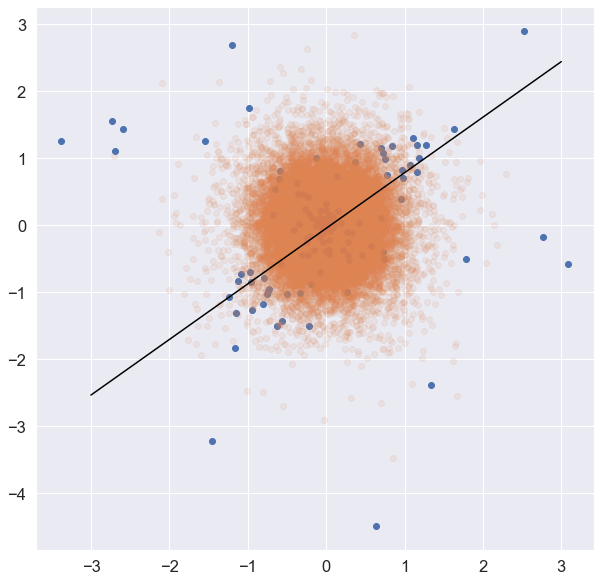

In [482]:
plt.figure(figsize=(10, 10))
plt.scatter(X3[y3 == 1]['Px'], X3[y3 == 1]['Py'], alpha=1)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Py'], alpha=0.1)

k, b = np.polyfit(X3[y3 == 1]['Px'][(np.abs(X3['Px'][y3 == 1]) < 1.2) * (np.abs(X3['Px'][y3 == 1]) > 0.7)], X3[y3 == 1]['Py'][(np.abs(X3['Px'][y3 == 1]) < 1.2) * (np.abs(X3['Px'][y3 == 1]) > 0.7)], deg=1)

x = np.linspace(-3, 3, 2)

plt.plot(x, k * x + b, 'black')

plt.show()

In [483]:
X3['centr_dist'] = X3['Px'] ** 2 + X3['Py'] ** 2
X3['line_dist'] = np.abs((X3['Py'] -  (k * X3['Px'] + b)) / (k ** 2 + 1) ** 0.5)

In [484]:
get_metrics(X3, y3)

method    recall  precision
0    log_reg  0.055764   0.515873
1        knn  0.000000   0.000000
2  rand_frst  0.083457   0.722222

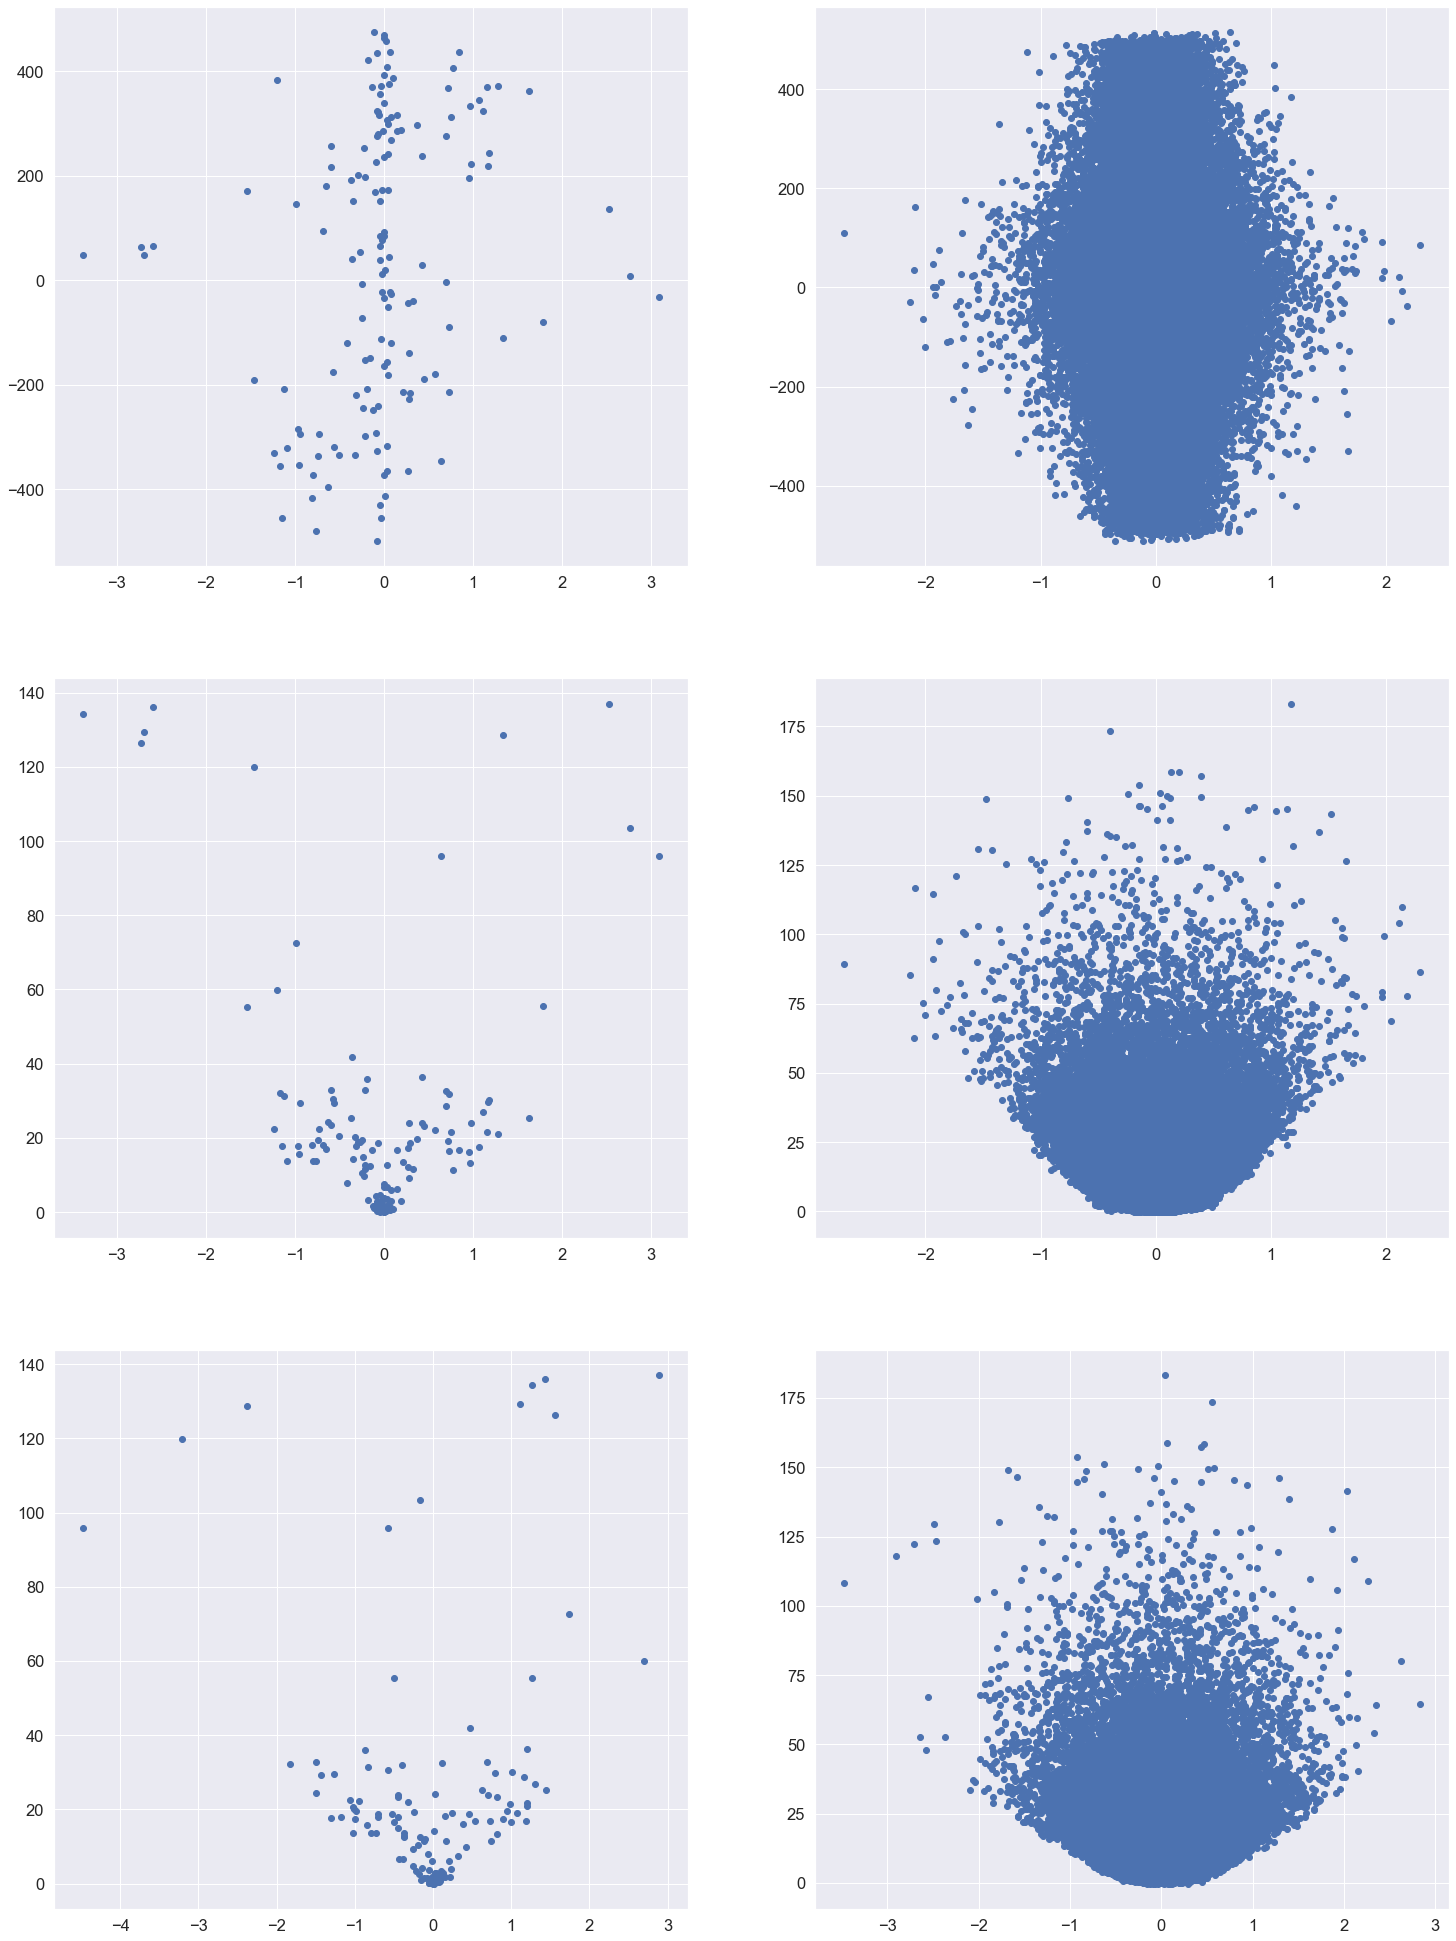

In [485]:
plt.figure(figsize=(25, 35))

plt.subplot(3, 2, 1)
plt.scatter(X3[y3 == 1]['Px'], X3[y3 == 1]['Y'])

plt.subplot(3, 2, 2)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Y'])

plt.subplot(3, 2, 3)
plt.scatter(X3[y3 == 1]['Px'], X3[y3 == 1]['Pz'])

plt.subplot(3, 2, 4)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Pz'])

plt.subplot(3, 2, 5)
plt.scatter(X3[y3 == 1]['Py'], X3[y3 == 1]['Pz'])

plt.subplot(3, 2, 6)
plt.scatter(X3[y3 == 0]['Py'], X3[y3 == 0]['Pz'])

plt.show()

In [486]:
X3['PyPz_div'] = np.where((X3['Pz'] < 40) * (X3['Pz'] > -20 * X3['Py'] - 10) * (X3['Pz'] > 20 * X3['Py'] - 10), 1, 0)
X3['PxPz_div'] = np.where((X3['Pz'] < 40) * (X3['Pz'] > -20 * X3['Px'] - 10) * (X3['Pz'] > 20 * X3['Px'] - 10), 1, 0)
X3['PxY_div'] = np.where(np.abs(X3['Px']) <  0.7, 1, 0)

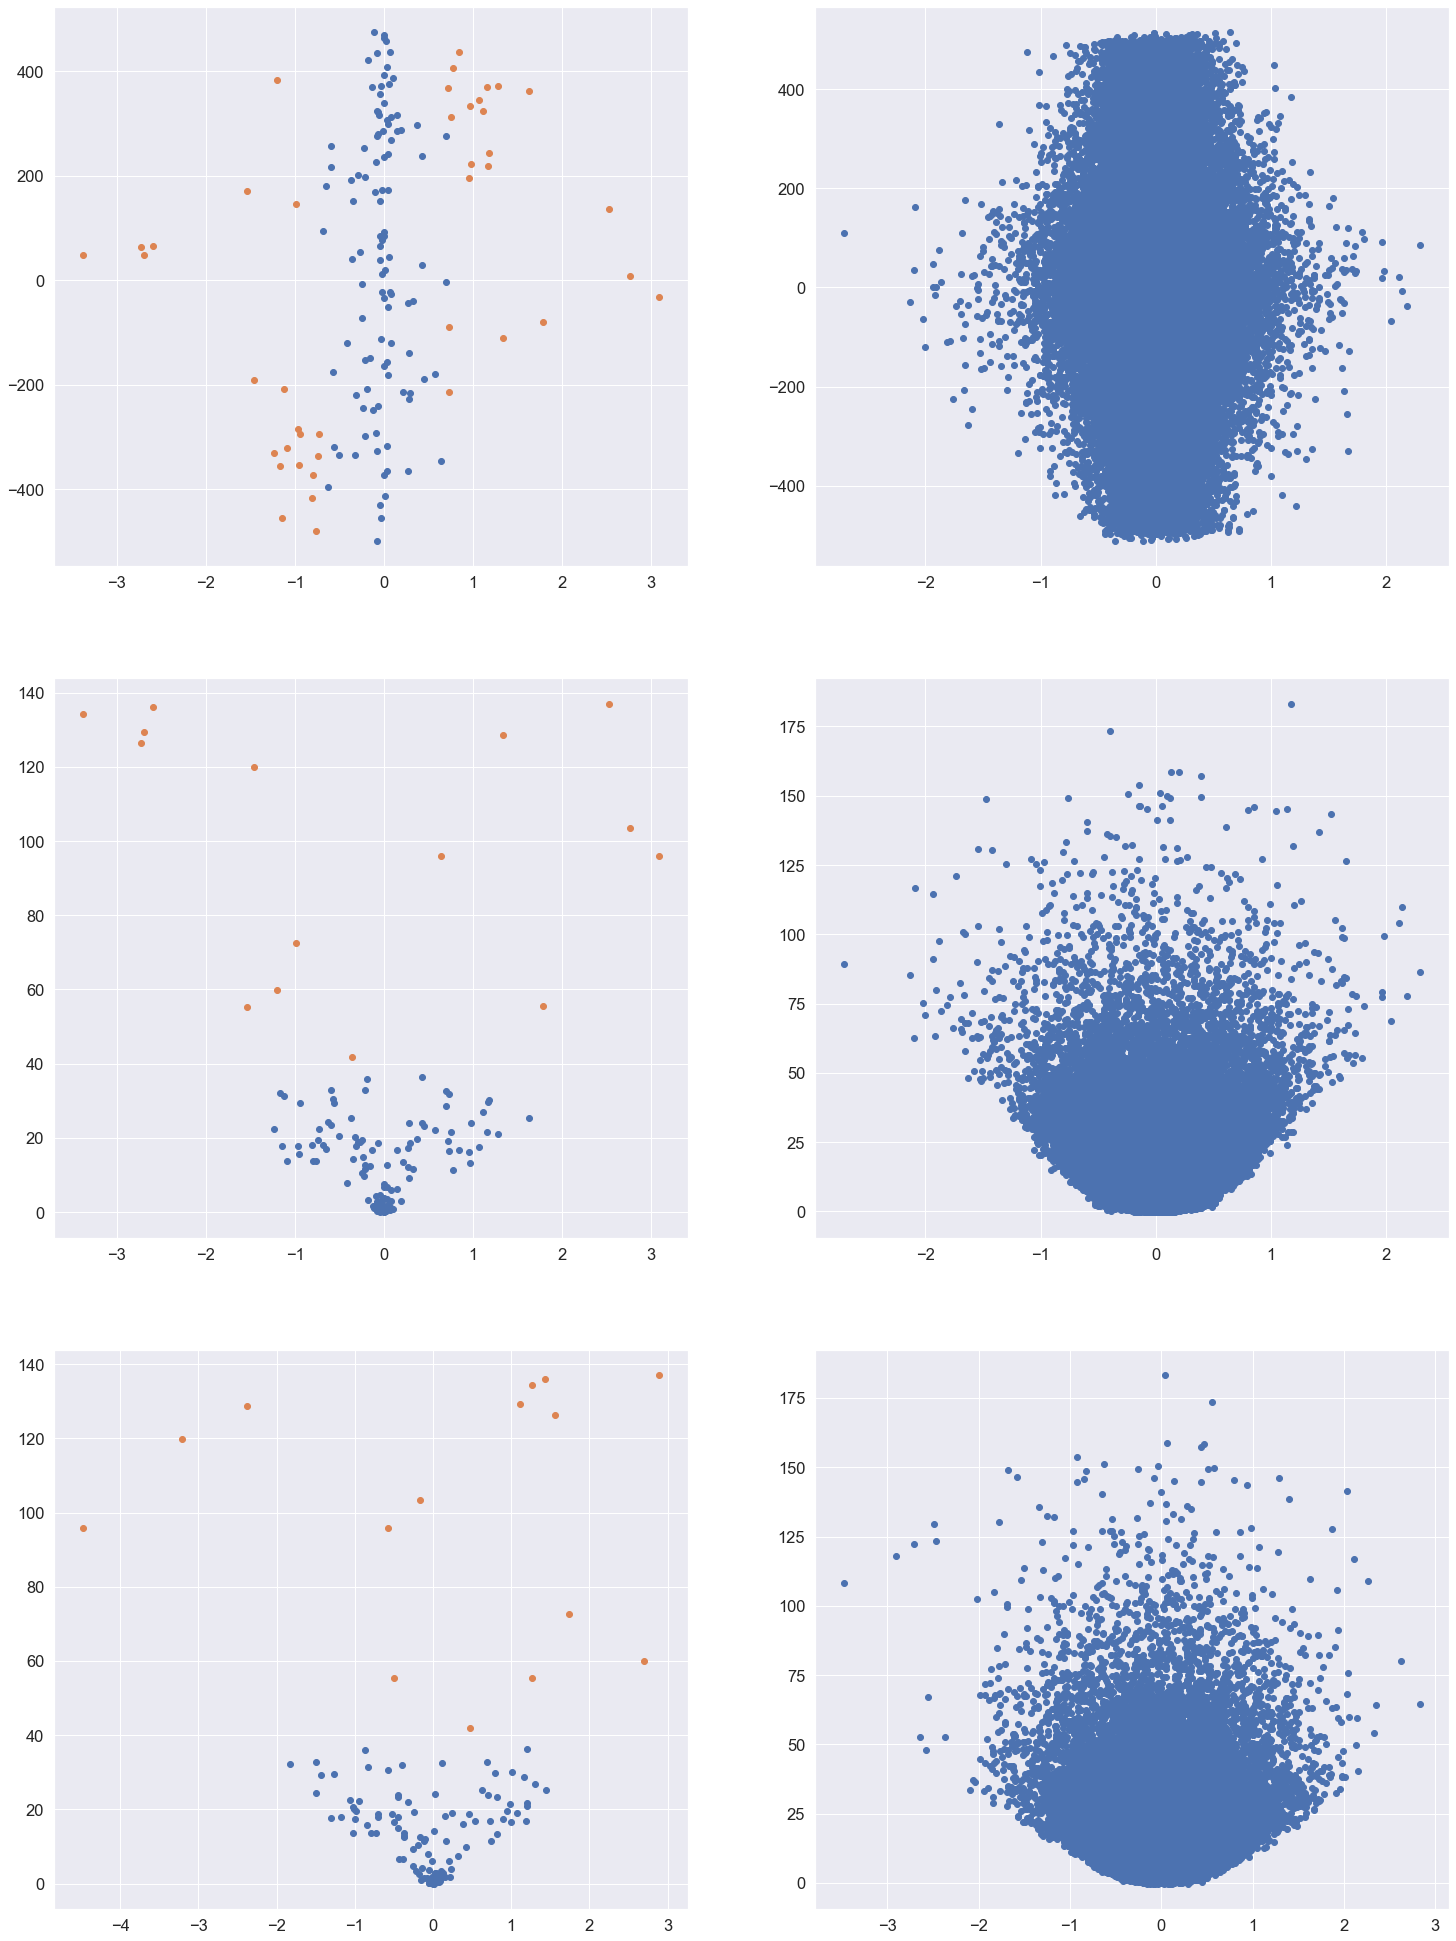

In [487]:
plt.figure(figsize=(25, 35))

plt.subplot(3, 2, 1)
plt.scatter(X3[(y3 == 1) * (X3['PxY_div'] == 1)]['Px'], X3[(y3 == 1) * (X3['PxY_div'] == 1)]['Y'])
plt.scatter(X3[(y3 == 1) * (X3['PxY_div'] == 0)]['Px'], X3[(y3 == 1) * (X3['PxY_div'] == 0)]['Y'])

plt.subplot(3, 2, 2)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Y'])

plt.subplot(3, 2, 3)
plt.scatter(X3[(y3 == 1) * (X3['PxPz_div'] == 1)]['Px'], X3[(y3 == 1) * (X3['PxPz_div'] == 1)]['Pz'])
plt.scatter(X3[(y3 == 1) * (X3['PxPz_div'] == 0)]['Px'], X3[(y3 == 1) * (X3['PxPz_div'] == 0)]['Pz'])

plt.subplot(3, 2, 4)
plt.scatter(X3[y3 == 0]['Px'], X3[y3 == 0]['Pz'])

plt.subplot(3, 2, 5)
plt.scatter(X3[(y3 == 1) * (X3['PyPz_div'] == 1)]['Py'], X3[(y3 == 1) * (X3['PyPz_div'] == 1)]['Pz'])
plt.scatter(X3[(y3 == 1) * (X3['PyPz_div'] == 0)]['Py'], X3[(y3 == 1) * (X3['PyPz_div'] == 0)]['Pz'])

plt.subplot(3, 2, 6)
plt.scatter(X3[y3 == 0]['Py'], X3[y3 == 0]['Pz'])

plt.show()

In [488]:
get_metrics(X3, y3)

method    recall  precision
0    log_reg  0.057054   0.552778
1        knn  0.000000   0.000000
2  rand_frst  0.094542   0.697487

In [489]:
cluster_metrics([X1[best1], X2[best2], X3], [y1, y2, y3])

method    recall  precision
0    log_reg  0.610691   0.945358
1        knn  0.572415   0.986885
2  rand_frst  0.616673   0.973016

In [491]:
cluster_metrics([X1, X2, X3], [y1, y2, y3])

method    recall  precision
0    log_reg  0.604364   0.955943
1        knn  0.571737   0.976225
2  rand_frst  0.619928   0.973085

In [ ]:
best3 = best_params(X3, y3, 100)

In [ ]:
get_metrics(X3[best3], y3)

method    recall  precision
0  log_reg  0.060526   0.629762
1      knn  0.004762   0.166667

In [ ]:
cluster_metrics([X1[best1], X2[best2], X3[best3]], [y1, y2, y3])

method    recall  precision
0  log_reg  0.621155   0.959895
1      knn  0.587178   0.989450

>## CatBoost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
rec1 = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3, random_state=i)

    y1_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)
    
    rec1.append(recall_score(y1_test, y1_pred))

rec1 = np.mean(rec1)

print(rec1)

0.9895731508634734


In [ ]:
rec2 = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3, random_state=i)

    y2_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)
    
    rec2.append(recall_score(y2_test, y2_pred))

rec2 = np.mean(rec2)

print(rec2)

0.98371686637618


In [ ]:
rec = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)

    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(X_train, y_train).predict(X_test)
    
    rec.append(recall_score(y3_test, y3_pred))

rec3 = np.mean(rec)

print(rec3)

0.07142274702772729


In [ ]:
rec = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3, random_state=i)
    y1_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)

    X_train, X_test, y_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3, random_state=i)
    y2_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)

    X_train, X_test, y_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)
    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(X_train, y_train).predict(X_test)

    y_pred = np.hstack((y1_pred, np.hstack((y2_pred, y3_pred))))
    y_test = np.hstack((y1_test, np.hstack((y2_test, y3_test))))
    
    rec.append(recall_score(y_test, y_pred))

rec = np.mean(rec)

print(rec)

0.6181825205592734


Нагенерить SMOTE частиц каждого класса
Обучить регрессию на каждом классе по отдельности

>## Over-Sampling при помощи SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
def get_metrics(X_train, X_test, y_train, y_test):

    log_reg_os = LogisticRegression(max_iter=100000).fit(X_train, y_train).predict(X_test)
    knn_os = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)

    return pd.DataFrame({'method': ['log_reg', 'knn'],
                         'recall': [recall_score(log_reg_os, y_test), recall_score(knn_os, y_test)],
                         'precision': [precision_score(log_reg_os, y_test), precision_score(knn_os, y_test)]})

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3)

In [ ]:
os = SMOTE(random_state=42)

columns = X1_train.columns

os_data_X1, os_data_y1 = os.fit_resample(X1_train, y1_train)

os_data_X1 = pd.DataFrame(data=os_data_X1, columns=columns)

In [ ]:
get_metrics(os_data_X1, X1_test, os_data_y1, y1_test)

method    recall  precision
0  log_reg  0.878049   1.000000
1      knn  0.945946   0.972222

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3)

In [ ]:
os = SMOTE(random_state=42)

columns = X2_train.columns

os_data_X2, os_data_y2 = os.fit_resample(X2_train, y2_train)

os_data_X2 = pd.DataFrame(data=os_data_X2, columns=columns)

In [ ]:
get_metrics(os_data_X2, X2_test, os_data_y2, y2_test)

method  recall  precision
0  log_reg     1.0        1.0
1      knn     1.0        1.0

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)

In [ ]:
os = SMOTE(random_state=42)

columns = X3_train.columns

os_data_X3, os_data_y3 = os.fit_resample(X3_train, y3_train)

os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

In [ ]:
get_metrics(os_data_X3, X3_test, os_data_y3, y3_test)

method    recall  precision
0  log_reg  0.006871   0.682927
1      knn  0.010739   0.414634

In [ ]:
rec3 = []
prs3 = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)

    os = SMOTE(random_state=i)

    columns = X_train.columns

    os_data_X3, os_data_y3 = os.fit_resample(X_train, y_train)

    os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(os_data_X3, os_data_y3).predict(X_test)
    
    rec3.append(recall_score(y3_test, y3_pred))
    prs3.append(precision_score(y3_test, y3_pred))

rec3 = np.mean(rec3)
prs3 = np.mean(prs3)

print('Recall score: {}'.format(rec3))
print('Precision score: {}'.format(prs3))

Recall score: 0.27872074740383207
Precision score: 0.08351639211473015


In [ ]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1[best1], y1, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X1_train.columns

    os_data_X1, os_data_y1 = os.fit_resample(X1_train, y1_train)

    os_data_X1 = pd.DataFrame(data=os_data_X1, columns=columns)

    y1_pred = ((LogisticRegression(max_iter=100000).fit(os_data_X1, os_data_y1).predict(X1_test) + KNeighborsClassifier().fit(os_data_X1, os_data_y1).predict(X1_test)) > 0)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2[best2], y2, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X2_train.columns

    os_data_X2, os_data_y2 = os.fit_resample(X2_train, y2_train)

    os_data_X2 = pd.DataFrame(data=os_data_X2, columns=columns)

    y2_pred = ((LogisticRegression(max_iter=100000).fit(os_data_X2, os_data_y2).predict(X2_test) + KNeighborsClassifier().fit(os_data_X2, os_data_y2).predict(X2_test)) > 0)
    
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X3_train.columns

    os_data_X3, os_data_y3 = os.fit_resample(X3_train, y3_train)

    os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

    y3_pred = CatBoostClassifier(cat_features=['PxPz_div', 'PyPz_div', 'PxY_div'], verbose=False).fit(os_data_X3, os_data_y3).predict(X3_test)
    
    y_pred = np.hstack((y1_pred, np.hstack((y2_pred, y3_pred))))
    y_test = np.hstack((y1_test, np.hstack((y2_test, y3_test))))
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.7099285370341019
Precision score: 0.3576515784638777


>## Ограничений на $P_z$

>## Baseline

In [1067]:
threshold = [0, 150]

X = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
y = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

In [1069]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.000000   0.000000
1        knn  0.013070   0.500000
2  rand_frst  0.074435   0.869444

>## Первая группа

In [1008]:
threshold = [50, 150]

X = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
y = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

In [1009]:
y[y == 1].size

15

In [891]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.000000   0.000000
1        knn  0.061111   0.333333
2  rand_frst  0.344444   0.611111

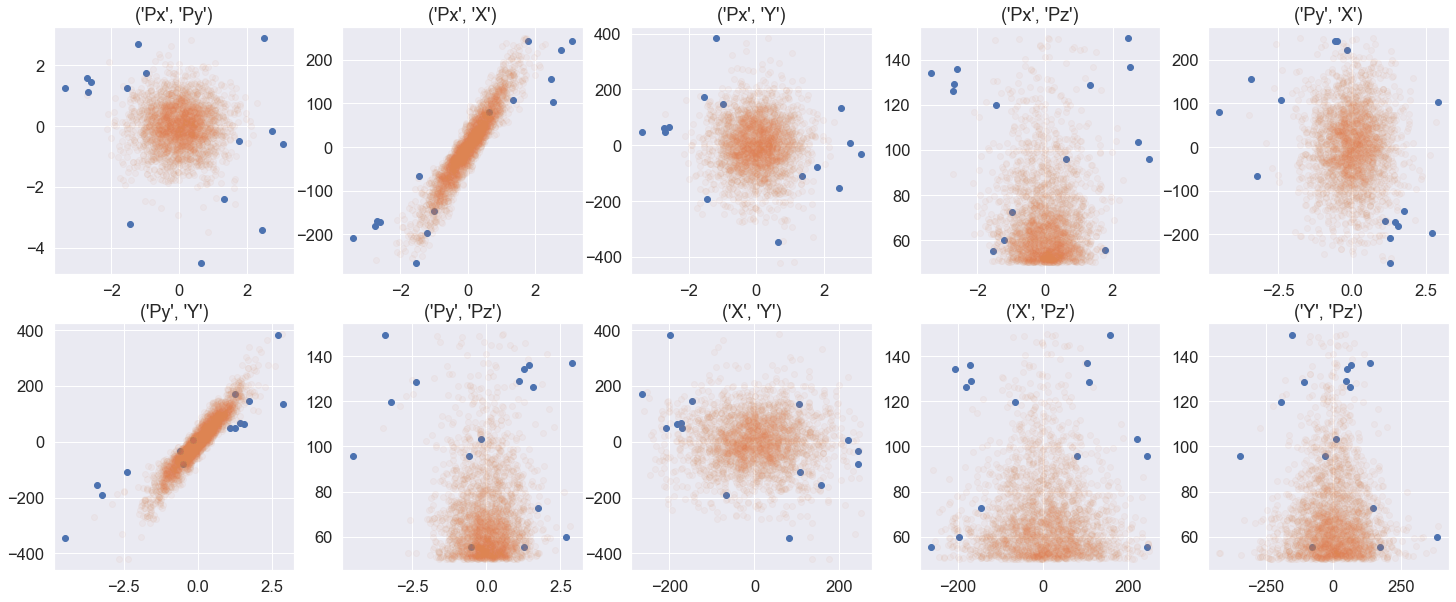

In [892]:
from itertools import combinations


plt.figure(figsize=(25, 10))

pairs = combinations(['Px', 'Py', 'X', 'Y', 'Pz'], 2)

for num, pair in enumerate(pairs, 1):

    plt.subplot(2, 5, num)
    plt.scatter(X[y == 1][pair[0]], X[y == 1][pair[1]])
    plt.scatter(X[y == 0][pair[0]], X[y == 0][pair[1]], alpha=0.05)
    plt.title(pair)

plt.show()

In [893]:
X['centr_dist1'] = X['Px'] ** 2 + X['Py'] ** 2
X['centr_dist2'] = X['Px'] ** 2 + X['Y'] ** 2
X['centr_dist2'] = X['Py'] ** 2 + X['X'] ** 2
X['centr_dist3'] = X['X'] ** 2 + X['Y'] ** 2

In [894]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.516667   0.861111
1        knn  0.000000   0.000000
2  rand_frst  0.372222   0.916667

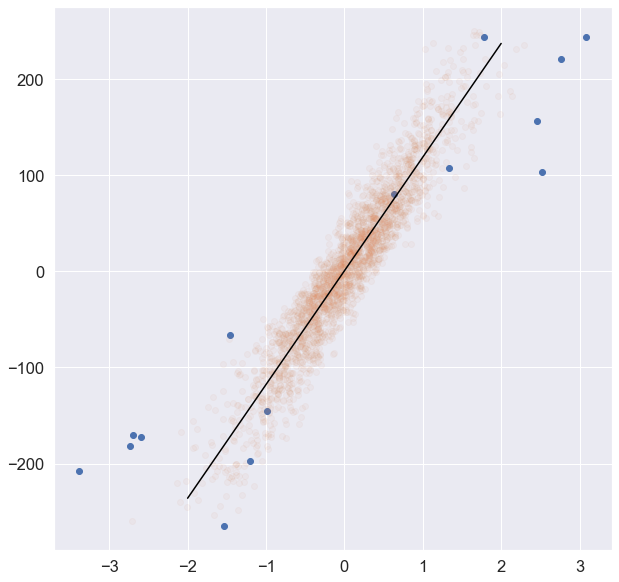

In [895]:
plt.figure(figsize=(10, 10))

plt.scatter(X[y == 1]['Px'], X[y == 1]['X'])
plt.scatter(X[y == 0]['Px'], X[y == 0]['X'], alpha=0.05)

k1, b1 = np.polyfit(X[y == 0]['Px'], X[y == 0]['X'], deg=1)

x = np.linspace(-2, 2, 2)

plt.plot(x, k1 * x + b1, 'black')

plt.show()

In [896]:
X['line_dist1'] = np.abs((X['X'] -  (k1 * X['Px'] + b1)) / (k1 ** 2 + 1) ** 0.5)

In [897]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.516667   0.861111
1        knn  0.000000   0.000000
2  rand_frst  0.400000   1.000000

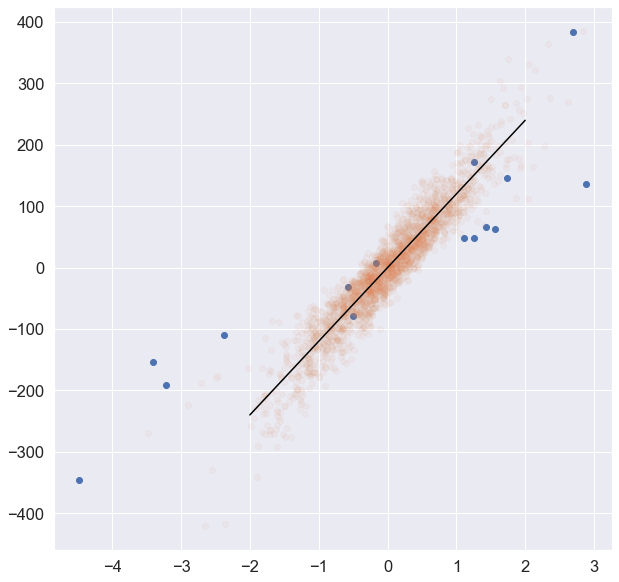

In [898]:
plt.figure(figsize=(10, 10))

plt.scatter(X[y == 1]['Py'], X[y == 1]['Y'])
plt.scatter(X[y == 0]['Py'], X[y == 0]['Y'], alpha=0.05)

k2, b2 = np.polyfit(X[y == 0]['Py'], X[y == 0]['Y'], deg=1)

x = np.linspace(-2, 2, 2)

plt.plot(x, k2 * x + b2, 'black')

plt.show()

In [899]:
X['line_dist2'] = np.abs((X['Y'] -  (k2 * X['Py'] + b2)) / (k2 ** 2 + 1) ** 0.5)

In [900]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.516667   0.861111
1        knn  0.000000   0.000000
2  rand_frst  0.427778   1.000000

>SMOTE

In [904]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = RandomForestClassifier(random_state=42, n_jobs=-1).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.43333333333333335
Precision score: 0.6416666666666667


In [905]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.7611111111111111
Precision score: 0.3392094017094018


In [906]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = KNeighborsClassifier(n_jobs=-1).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.3444444444444445
Precision score: 0.029302343237677646


>GridSearch

In [908]:
from sklearn.model_selection import GridSearchCV

rec1 = []
prs1 = []
best11 = []

params = {'n_estimators': np.arange(100, 1000, 100), 'criterion' : ['gini', 'entropy', 'log_loss'], 'min_samples_leaf': np.arange(1, 10, 1)}

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    search1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, scoring='recall', cv=3, n_jobs=-1)

    search1.fit(os_data_X, os_data_y)

    y_pred1 = search1.predict(X_test)
    
    rec1.append(recall_score(y_test1, y_pred1))
    prs1.append(precision_score(y_test1, y_pred1))

    best11.append(search1.best_params_)

print('Recall score: {}'.format(np.mean(rec1)))
print('Precision score: {}'.format(np.mean(prs1)))

Recall score: 0.5777777777777778
Precision score: 0.5833333333333334


In [923]:
best11

NameError: name 'best11' is not defined

In [913]:
rec1 = []
prs1 = []
best12 = []

params = {'penalty': ['l2', 'l1'], 'C' : np.arange(1, 10, 1), 'tol': np.arange(0.001, 0.01, 0.001)}

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    search1 = GridSearchCV(estimator=LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000), param_grid=params, scoring='recall', cv=3, n_jobs=-1)

    search1.fit(os_data_X, os_data_y)

    y_pred1 = search1.predict(X_test)
    
    rec1.append(recall_score(y_test1, y_pred1))
    prs1.append(precision_score(y_test1, y_pred1))

    best12.append(search1.best_params_)

print('Recall score: {}'.format(np.mean(rec1)))
print('Precision score: {}'.format(np.mean(prs1)))

Recall score: 0.7611111111111111
Precision score: 0.3392094017094018


In [922]:
best12

[{'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 1, 'penalty': 'l2', 'tol': 0.001}]

>catboost

In [927]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=i)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = CatBoostClassifier(verbose=False).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.5222222222222223
Precision score: 0.4075396825396825


>## Вторая группа

In [1004]:
threshold = [10, 50]

X = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
y = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

In [1005]:
y[y == 1].size

69

In [933]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.000000   0.000000
1        knn  0.000000   0.000000
2  rand_frst  0.080473   0.777778

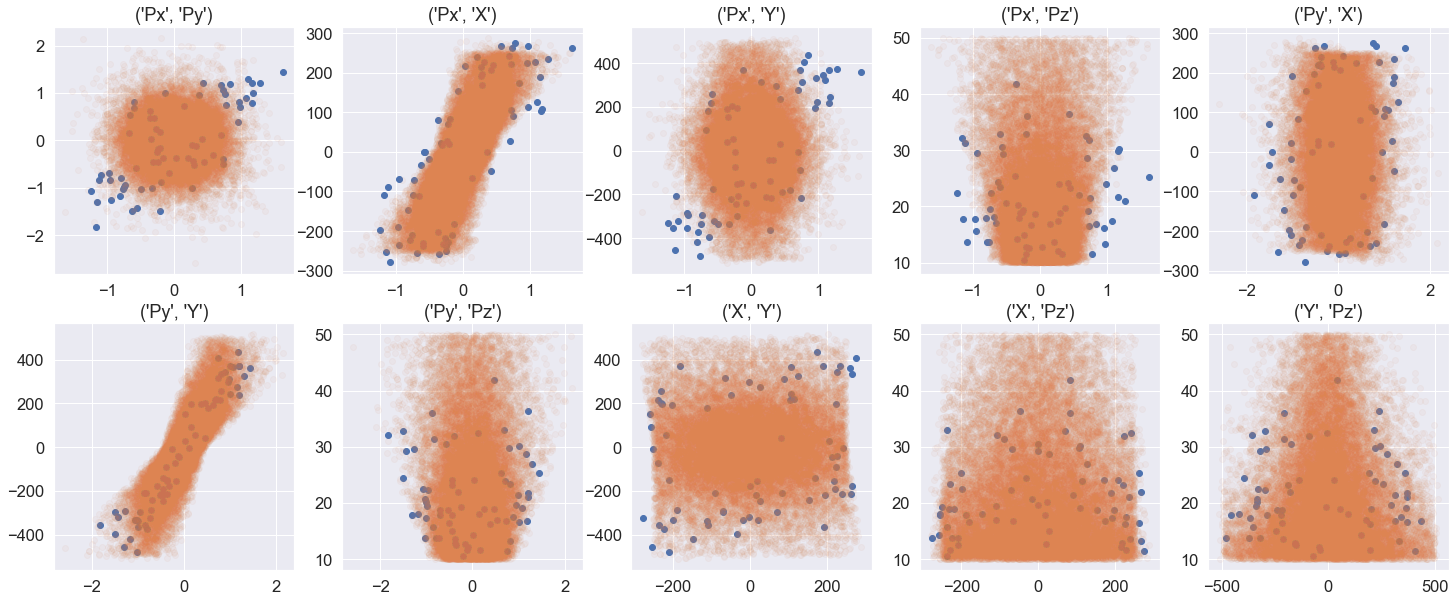

In [934]:
from itertools import combinations


plt.figure(figsize=(25, 10))

pairs = combinations(['Px', 'Py', 'X', 'Y', 'Pz'], 2)

for num, pair in enumerate(pairs, 1):

    plt.subplot(2, 5, num)
    plt.scatter(X[y == 1][pair[0]], X[y == 1][pair[1]])
    plt.scatter(X[y == 0][pair[0]], X[y == 0][pair[1]], alpha=0.05)
    plt.title(pair)

plt.show()

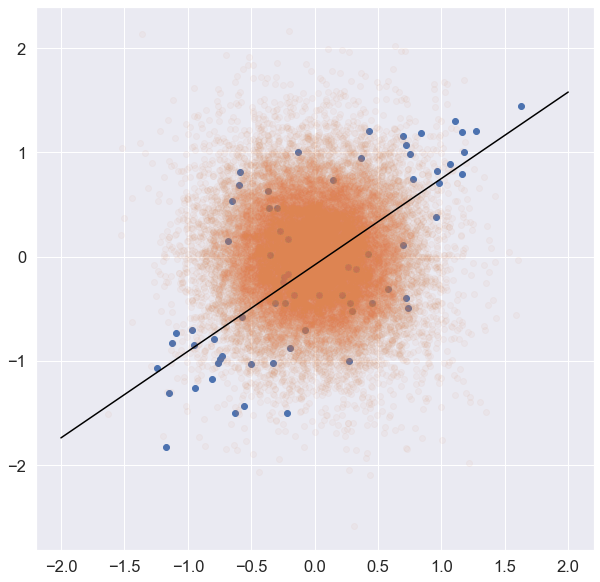

In [935]:
plt.figure(figsize=(10, 10))

plt.scatter(X[y == 1]['Px'], X[y == 1]['Py'])
plt.scatter(X[y == 0]['Px'], X[y == 0]['Py'], alpha=0.05)

k1, b1 = np.polyfit(X[y == 1]['Px'], X[y == 1]['Py'], deg=1)

x = np.linspace(-2, 2, 2)

plt.plot(x, k1 * x + b1, 'black')

plt.show()

In [936]:
X['centr_dist1'] = X['Px'] ** 2 + X['Py'] ** 2
X['line_dist1'] = np.abs((X['Py'] -  (k1 * X['Px'] + b1)) / (k1 ** 2 + 1) ** 0.5)

In [937]:
get_metrics(X, y)

method    recall  precision
0    log_reg  0.038730   0.500000
1        knn  0.000000   0.000000
2  rand_frst  0.079711   0.833333

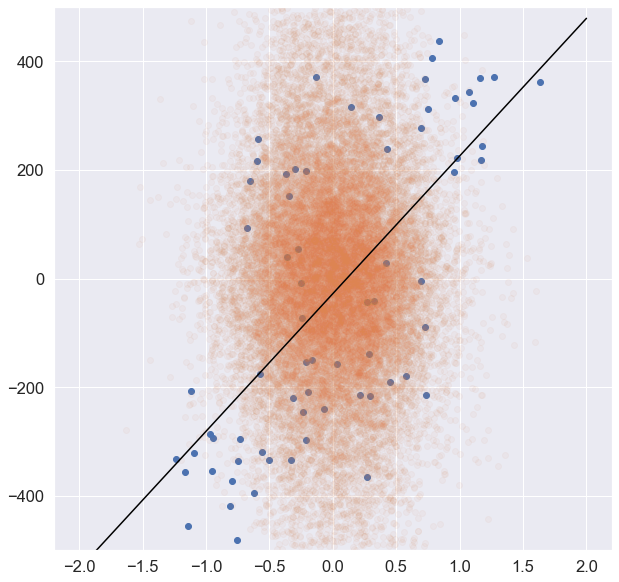

In [938]:
plt.figure(figsize=(10, 10))

plt.scatter(X[y == 1]['Px'], X[y == 1]['Y'])
plt.scatter(X[y == 0]['Px'], X[y == 0]['Y'], alpha=0.05)

k2, b2 = np.polyfit(X[y == 1]['Px'], X[y == 1]['Y'], deg=1)

x = np.linspace(-2, 2, 2)

plt.plot(x, k2 * x + b2, 'black')

plt.ylim(-500, 500)

plt.show()

In [939]:
X['axis_dist_Px'] = np.abs(X['Px'])

In [940]:
get_metrics(X.drop(['Px'], axis=1), y)

method    recall  precision
0    log_reg  0.063969   0.694444
1        knn  0.000000   0.000000
2  rand_frst  0.106291   0.833333

>SMOTE

In [944]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = RandomForestClassifier(random_state=42, n_jobs=-1).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.30057573485984285
Precision score: 0.14633704641908088


In [945]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.551243128435782
Precision score: 0.008440837088442328


In [946]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = KNeighborsClassifier(n_jobs=-1).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.41226369769660626
Precision score: 0.011044382006494498


>GridSearch

In [949]:
from sklearn.model_selection import GridSearchCV

rec1 = []
prs1 = []
best21 = []

params = {'n_estimators': np.arange(100, 500, 100), 'criterion' : ['gini', 'entropy'], 'min_samples_leaf': np.arange(1, 5, 1)}

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    search1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, scoring='recall', cv=3, n_jobs=-1)

    search1.fit(os_data_X, os_data_y)

    y_pred1 = search1.predict(X_test)
    
    rec1.append(recall_score(y_test1, y_pred1))
    prs1.append(precision_score(y_test1, y_pred1))

    best21.append(search1.best_params_)

print('Recall score: {}'.format(np.mean(rec1)))
print('Precision score: {}'.format(np.mean(prs1)))

Recall score: 0.29965619462995774
Precision score: 0.14679720153553005


In [950]:
best21

[{'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 300},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 400},
 {'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 200},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 300}]

In [951]:
rec1 = []
prs1 = []
best22 = []

params = {'penalty': ['l2', 'l1'], 'C' : np.arange(1, 10, 1), 'tol': np.arange(0.001, 0.01, 0.001)}

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    search1 = GridSearchCV(estimator=LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000), param_grid=params, scoring='recall', cv=3, n_jobs=-1)

    search1.fit(os_data_X, os_data_y)

    y_pred1 = search1.predict(X_test)
    
    rec1.append(recall_score(y_test1, y_pred1))
    prs1.append(precision_score(y_test1, y_pred1))

    best22.append(search1.best_params_)

print('Recall score: {}'.format(np.mean(rec1)))
print('Precision score: {}'.format(np.mean(prs1)))

Recall score: 0.551243128435782
Precision score: 0.008479493485302343


In [952]:
best22

[{'C': 7, 'penalty': 'l2', 'tol': 0.001},
 {'C': 2, 'penalty': 'l2', 'tol': 0.001},
 {'C': 3, 'penalty': 'l2', 'tol': 0.001},
 {'C': 5, 'penalty': 'l2', 'tol': 0.001},
 {'C': 3, 'penalty': 'l2', 'tol': 0.001},
 {'C': 7, 'penalty': 'l2', 'tol': 0.001}]

>catboost

In [953]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=i)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = CatBoostClassifier(verbose=False).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.45059595202398794
Precision score: 0.14221222627655375


>## Третья группа

In [1045]:
threshold = [0, 10]

X = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
y = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

In [1023]:
y[y == 1].size

62

In [1024]:
get_metrics(X, y)

method  recall  precision
0    log_reg     0.0        0.0
1        knn     0.0        0.0
2  rand_frst     0.0        0.0

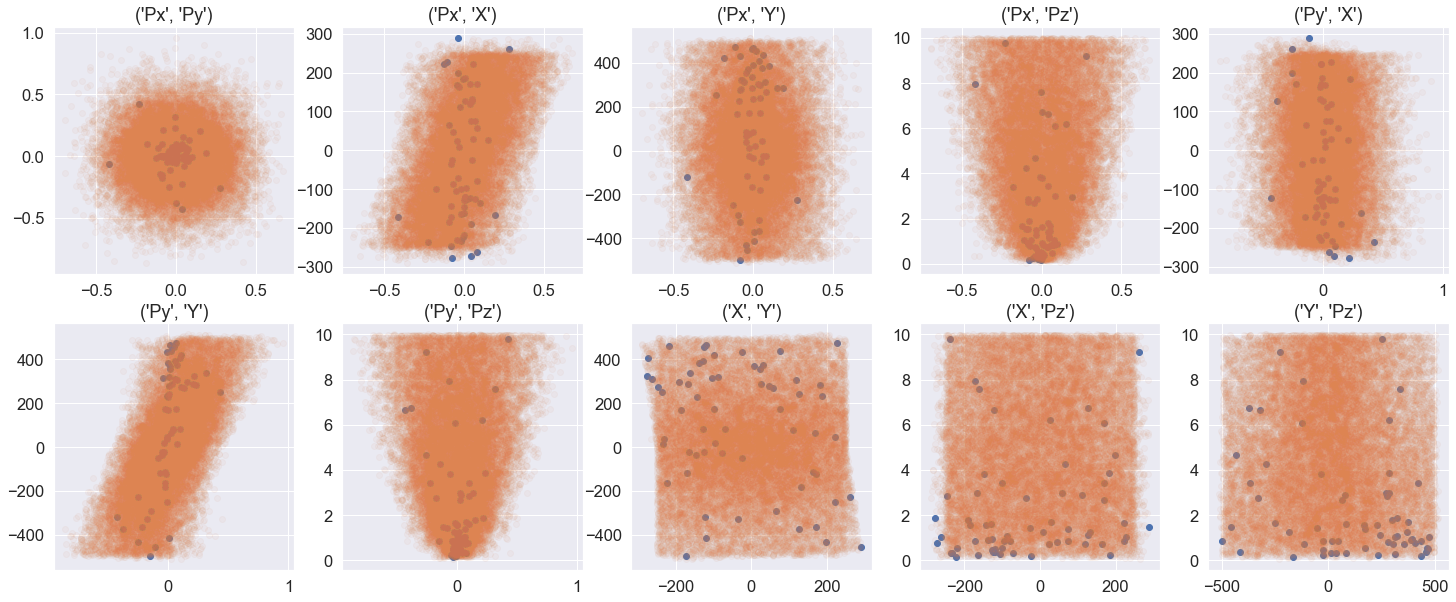

In [1025]:
from itertools import combinations


plt.figure(figsize=(25, 10))

pairs = combinations(['Px', 'Py', 'X', 'Y', 'Pz'], 2)

for num, pair in enumerate(pairs, 1):

    plt.subplot(2, 5, num)
    plt.scatter(X[y == 1][pair[0]], X[y == 1][pair[1]])
    plt.scatter(X[y == 0][pair[0]], X[y == 0][pair[1]], alpha=0.05)
    plt.title(pair)

plt.show()

Добавим признаки

In [1046]:
X['centr_dist1'] = X['Px'] ** 2 + X['Py'] ** 2
X['axis_dist_Px'] = np.abs(X['Px'])
X['axis_dist_Py'] = np.abs(X['Py'])

In [1027]:
get_metrics(X.drop([], axis=1), y)

method  recall  precision
0    log_reg     0.0        0.0
1        knn     0.0        0.0
2  rand_frst     0.0        0.0

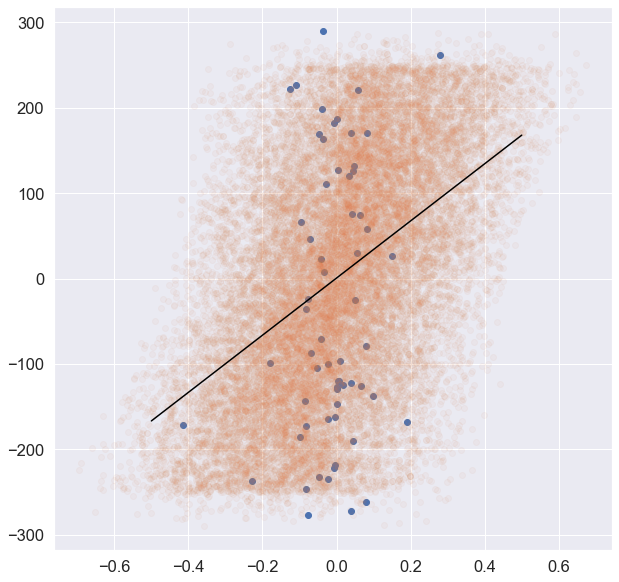

In [1047]:
plt.figure(figsize=(10, 10))

plt.scatter(X[y == 1]['Px'], X[y == 1]['X'])
plt.scatter(X[y == 0]['Px'], X[y == 0]['X'], alpha=0.05)

k1, b1 = np.polyfit(X[y == 0]['Px'], X[y == 0]['X'], deg=1)

x = np.linspace(-0.5, 0.5, 2)

plt.plot(x, k1 * x + b1, 'black')

plt.show()

In [1048]:
X['line_dist1'] = np.abs((X['X'] -  (k1 * X['Px'] + b1)) / (k1 ** 2 + 1) ** 0.5)

In [1030]:
get_metrics(X, y)

method  recall  precision
0    log_reg     0.0        0.0
1        knn     0.0        0.0
2  rand_frst     0.0        0.0

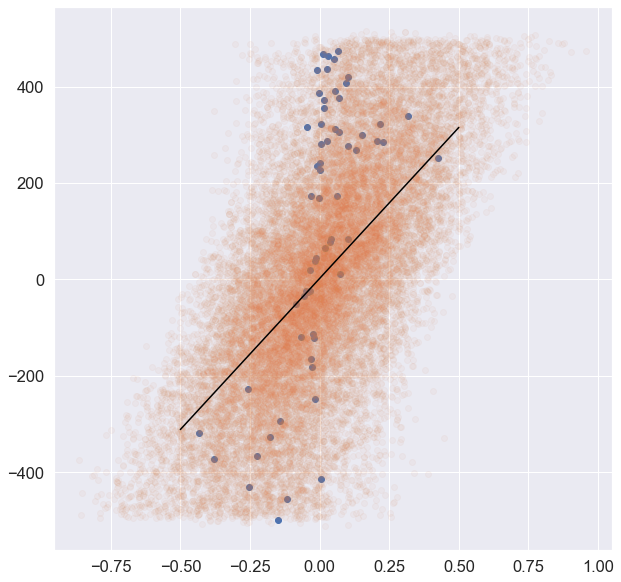

In [1049]:
plt.figure(figsize=(10, 10))

plt.scatter(X[y == 1]['Py'], X[y == 1]['Y'])
plt.scatter(X[y == 0]['Py'], X[y == 0]['Y'], alpha=0.05)

k2, b2 = np.polyfit(X[y == 0]['Py'], X[y == 0]['Y'], deg=1)

x = np.linspace(-0.5, 0.5, 2)

plt.plot(x, k2 * x + b2, 'black')

plt.show()

In [1050]:
X['line_dist2'] = np.abs((X['Y'] -  (k2 * X['Py'] + b2)) / (k2 ** 2 + 1) ** 0.5)

In [1033]:
get_metrics(X, y)

method  recall  precision
0    log_reg     0.0        0.0
1        knn     0.0        0.0
2  rand_frst     0.0        0.0

In [1051]:
X['in_center1'] = np.where(X['Px'] ** 2 + X['Py'] ** 2 < 0.01, 1, 0)
X['in_center2'] = np.where(np.abs(X['Px']) < 0.1, 1, 0)
X['in_center3'] = np.where(np.abs(X['Py']) < 0.1, 1, 0)

In [1035]:
get_metrics(X, y)

method  recall  precision
0    log_reg     0.0        0.0
1        knn     0.0        0.0
2  rand_frst     0.0        0.0

>SMOTE

In [1036]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = RandomForestClassifier(random_state=42, n_jobs=-1).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.06633926714018247
Precision score: 0.05510482398354252


In [1037]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.7689762119395986
Precision score: 0.011108827769059956


In [1038]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = KNeighborsClassifier(n_jobs=-1).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.18126258911441975
Precision score: 0.0037700139320810517


>GridSearch

In [1039]:
from sklearn.model_selection import GridSearchCV

rec1 = []
prs1 = []
best31 = []

params = {'n_estimators': np.arange(100, 500, 100), 'criterion' : ['gini', 'entropy'], 'min_samples_leaf': np.arange(1, 5, 1)}

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    search1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, scoring='recall', cv=3, n_jobs=-1)

    search1.fit(os_data_X, os_data_y)

    y_pred1 = search1.predict(X_test)
    
    rec1.append(recall_score(y_test1, y_pred1))
    prs1.append(precision_score(y_test1, y_pred1))

    best31.append(search1.best_params_)

print('Recall score: {}'.format(np.mean(rec1)))
print('Precision score: {}'.format(np.mean(prs1)))

Recall score: 0.06633926714018247
Precision score: 0.05510482398354252


In [1040]:
best31

[{'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100},
 {'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 200},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 100},
 {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 300}]

In [1041]:
rec1 = []
prs1 = []
best32 = []

params = {'penalty': ['l2', 'l1'], 'C' : np.arange(1, 10, 1), 'tol': np.arange(0.001, 0.01, 0.001)}

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=42, n_jobs=-1)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    search1 = GridSearchCV(estimator=LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000), param_grid=params, scoring='recall', cv=3, n_jobs=-1)

    search1.fit(os_data_X, os_data_y)

    y_pred1 = search1.predict(X_test)
    
    rec1.append(recall_score(y_test1, y_pred1))
    prs1.append(precision_score(y_test1, y_pred1))

    best32.append(search1.best_params_)

print('Recall score: {}'.format(np.mean(rec1)))
print('Precision score: {}'.format(np.mean(prs1)))

Recall score: 0.7570714500348368
Precision score: 0.011108654476805278


In [1042]:
best32

[{'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 5, 'penalty': 'l2', 'tol': 0.001},
 {'C': 2, 'penalty': 'l2', 'tol': 0.001},
 {'C': 1, 'penalty': 'l2', 'tol': 0.001},
 {'C': 9, 'penalty': 'l2', 'tol': 0.001},
 {'C': 3, 'penalty': 'l2', 'tol': 0.001}]

>catboost

In [1052]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    os = SMOTE(random_state=i)

    columns = X_train.columns

    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

    y_pred = CatBoostClassifier(verbose=False, cat_features=['in_center1', 'in_center2', 'in_center3']).fit(os_data_X, os_data_y).predict(X_test)
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.10674801298371094
Precision score: 0.043770386390235005


>## Соединение

In [1066]:
rec = []
prs = []

for i in [0, 6, 7, 13, 42, 911]:

    threshold = [50, 150]

    X1 = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
    y1 = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

    X1['centr_dist1'] = X1['Px'] ** 2 + X1['Py'] ** 2
    X1['centr_dist2'] = X1['Px'] ** 2 + X1['Y'] ** 2
    X1['centr_dist2'] = X1['Py'] ** 2 + X1['X'] ** 2
    X1['centr_dist3'] = X1['X'] ** 2 + X1['Y'] ** 2

    k1, b1 = np.polyfit(X1[y1 == 0]['Px'], X1[y1 == 0]['X'], deg=1)
    X1['line_dist1'] = np.abs((X1['X'] -  (k1 * X1['Px'] + b1)) / (k1 ** 2 + 1) ** 0.5)
    
    k2, b2 = np.polyfit(X1[y1 == 0]['Py'], X1[y1 == 0]['Y'], deg=1)
    X1['line_dist2'] = np.abs((X1['Y'] -  (k2 * X1['Py'] + b2)) / (k2 ** 2 + 1) ** 0.5)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3)

    os = SMOTE(random_state=42, n_jobs=-1)
    columns = X1_train.columns
    os_data_X1, os_data_y1 = os.fit_resample(X1_train, y1_train)
    os_data_X1 = pd.DataFrame(data=os_data_X1, columns=columns)

    y1_pred = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000).fit(os_data_X1, os_data_y1).predict(X1_test)

    ###

    threshold = [10, 50]

    X2 = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
    y2 = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

    k1, b1 = np.polyfit(X2[y2 == 1]['Px'], X2[y2 == 1]['Py'], deg=1)
    X2['centr_dist1'] = X2['Px'] ** 2 + X2['Py'] ** 2
    X2['line_dist1'] = np.abs((X2['Py'] -  (k1 * X2['Px'] + b1)) / (k1 ** 2 + 1) ** 0.5)
    X2['axis_dist_Px'] = np.abs(X2['Px'])

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)

    os = SMOTE(random_state=42, n_jobs=-1)
    columns = X2_train.columns
    os_data_X2, os_data_y2 = os.fit_resample(X2_train, y2_train)
    os_data_X2 = pd.DataFrame(data=os_data_X2, columns=columns)

    y2_pred = CatBoostClassifier(verbose=False, random_state=42).fit(os_data_X2, os_data_y2).predict(X2_test)

    ###

    threshold = [0, 10]

    X3 = data.drop(['type'], axis=1)[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]
    y3 = data[(data['Pz'] > threshold[0]) * (data['Pz'] < threshold[1])]['type']

    X3['centr_dist1'] = X3['Px'] ** 2 + X3['Py'] ** 2
    X3['axis_dist_Px'] = np.abs(X3['Px'])
    X3['axis_dist_Py'] = np.abs(X3['Py'])

    k1, b1 = np.polyfit(X3[y3 == 0]['Px'], X3[y3 == 0]['X'], deg=1)
    X3['line_dist1'] = np.abs((X3['X'] -  (k1 * X3['Px'] + b1)) / (k1 ** 2 + 1) ** 0.5)
    k2, b2 = np.polyfit(X3[y3 == 0]['Py'], X3[y3 == 0]['Y'], deg=1)
    X3['line_dist2'] = np.abs((X3['Y'] -  (k2 * X3['Py'] + b2)) / (k2 ** 2 + 1) ** 0.5)

    X3['in_center1'] = np.where(X3['Px'] ** 2 + X3['Py'] ** 2 < 0.01, 1, 0)
    X3['in_center2'] = np.where(np.abs(X3['Px']) < 0.1, 1, 0)
    X3['in_center3'] = np.where(np.abs(X3['Py']) < 0.1, 1, 0)

    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)

    os = SMOTE(random_state=42, n_jobs=-1)
    columns = X3_train.columns
    os_data_X3, os_data_y3 = os.fit_resample(X3_train, y3_train)
    os_data_X3 = pd.DataFrame(data=os_data_X3, columns=columns)

    y3_pred = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100000, C=3.5).fit(os_data_X3, os_data_y3).predict(X3_test)

    y_pred = np.hstack((y1_pred, np.hstack((y2_pred, y3_pred))))
    y_test = np.hstack((y1_test, np.hstack((y2_test, y3_test))))
    
    rec.append(recall_score(y_test, y_pred))
    prs.append(precision_score(y_test, y_pred))

rec = np.mean(rec)
prs = np.mean(prs)

print('Recall score: {}'.format(rec))
print('Precision score: {}'.format(prs))

Recall score: 0.6067513042513042
Precision score: 0.02032959136455154
